_Author: A. Spiga_

ALL TXT FILES FOR DD FOR VALID SOLS MUST HAVE BEEN COMPUTED
see ddstats_create first

In [1]:
import numpy as np
import apss_lib
import ppplot
import matplotlib.pyplot as mpl
%matplotlib inline

2019-12-13 17:16:53.034496


In [2]:
seasontab = ["natgeo"]
solboundtab = [(1,220)] # would be better with a dictionary with label season

In [3]:
soltab, ratiotab = np.loadtxt("./sol.txt",unpack=True)
ns = len(seasontab)
for iii in range(ns):    
    season = seasontab[iii]
    ssol,esol = solboundtab[iii]
    ###
    print season
    dafile = open("./sol_"+season+".txt","w")
    solinterv = np.arange(ssol,esol+1,1)
    for sol in solinterv:
        w = (soltab == sol)
        dafile.write( '%03d %5.3f\n' % (soltab[w][0],ratiotab[w][0]))
    dafile.close()

natgeo


In [4]:
for season in seasontab:

    ### create event structured arrays
    dtype = np.dtype([('drop',float), ('ltst',float), ('sol',int), ('utc','S23'), ('ratio',float)])
    events = np.array([],dtype=dtype)

    ### ratio: full sols have ratio=1
    sol, ratio = np.loadtxt("./sol_"+season+".txt",unpack=True)

    for iii in np.arange(sol.size):
      
        if ratio[iii] > 0.5:
    
            fifi, output = apss_lib.namefile(sol[iii],"")
            ddfile = "./output/txt_per_sol/"+output+"DD_3.txt"
    
            ltst = np.loadtxt(ddfile,unpack=True,dtype=str,usecols=(2))
            ltst = apss_lib.ltstfloat(ltst)
    
            drop = np.loadtxt(ddfile,unpack=True,usecols=(1))
            utc = np.loadtxt(ddfile,unpack=True,usecols=(3),dtype='S23')
        
            nnn = drop.size
            if nnn > 1:
                for n in np.arange(nnn):
                    element = np.array((drop[n],ltst[n],sol[iii],utc[n],ratio[iii]),dtype=dtype)
                    events = np.append(events,element)
            else:
                events = np.append(events,np.array((drop,ltst,sol[iii],utc,ratio[iii]),dtype=dtype))

    np.save(season+".npy",events)
    print events.size
    
    w = (np.abs(events['drop']) >= 0.5)
    print len(events['drop'][w])

3447
1012


In [5]:
for season in seasontab:
    
    events = np.load(season+".npy")
    
    ### ordered file
    oevents = np.sort(events, order='drop')
    dafile = open("./alldrop_ordered.txt","w")
    dafile.write('%6s ; %6s ; %3s ; %23s ; %5s\n' % ("_DROP_","_LTST_","SOL","YYYY-MM-DDTHH:MM:SS.sss","RATIO"))
    for ooo in oevents:
        dafile.write('%6.3f ; %6.3f ; %03d ; %s ; %5.3f\n' % (ooo['drop'],ooo['ltst'],ooo['sol'],ooo['utc'],ooo['ratio']))
    dafile.close()

    dafile = open("./alldrop_ordered_latex.txt","w")
    dafile.write('%5s & %5s & %3s \\\\ \n' % (" DROP","LTST ","SOL"))
    for ooo in oevents:
        dafile.write('%5.2f & %5.2f & %03d \\\\ \n' % (ooo['drop'],ooo['ltst'],ooo['sol']))
    dafile.close()

196.00400000000002
('MPFdP', 'MPFEvSol', 'PHXdP', 'PHXEvSol', 'MSLdP', 'MSLEvSol')


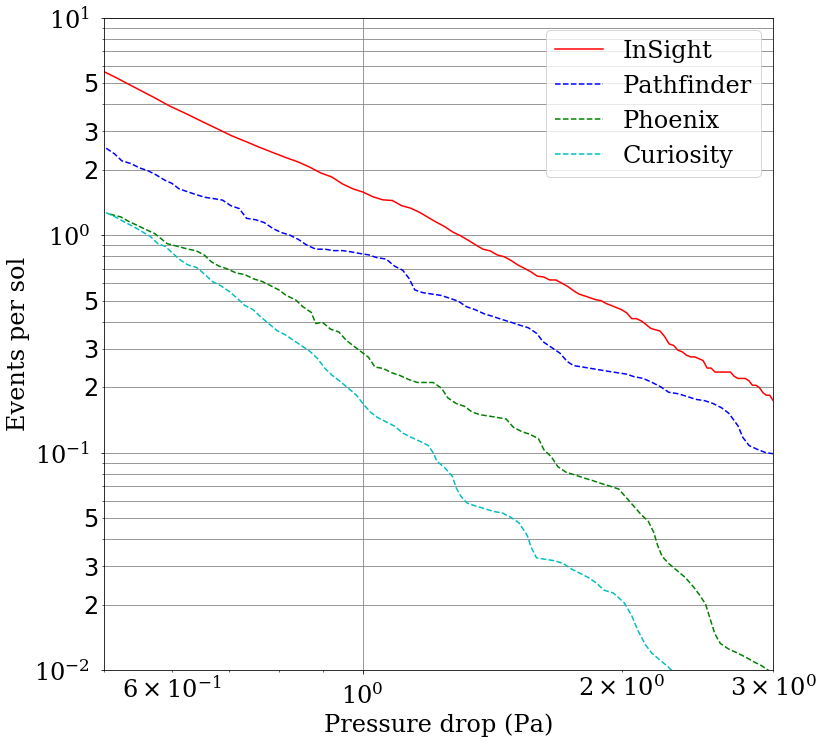

In [6]:
ppplot.changefont(24)
#fig = ppplot.figuref(x=12,y=8)
fig = ppplot.figuref(x=12,y=12)
pl = ppplot.plot1d(fig=fig)
pl.linestyle = ""

for season in seasontab:

    events = np.load(season+".npy")    
    
    sol, ratio = np.loadtxt("./sol_"+season+".txt",unpack=True)
    nsol = np.sum(ratio)
    print nsol
    ################# LT HISTOGRAM
    limdrop = 0.3
    w = np.where(events['drop'] <= -limdrop)
    what_hist = events['drop'][w]
    n, bins, patches = mpl.hist(what_hist,cumulative=True,bins='auto')
    bins = bins[:-1]

    pl.f = n/nsol
    pl.x = -bins
    pl.logx = True
    pl.logy = True
    pl.ymin = 0.01 #0.001 # Fig15 OE18
    pl.ymax = 10 
    pl.xmin = 0.5
    pl.xmax = 3 #5
    pl.marker = ''
    pl.ylabel = "Events per sol"
    pl.xlabel = 'Pressure drop (Pa)'
    pl.color = 'r'
    
    pl.linestyle = pl.linestyle + "-"
    
    pl.legend = "InSight (this study, %i sols)" % (nsol)
    pl.legend = "InSight" #(%i sols)" % (nsol)
    pl.make()

    NSYdP = pl.x
    NSYEvSol = pl.f

    datafile = "/home/aspiga/data/InSight/Ordonez_VortexStats_RL190225.csv"

    data = np.genfromtxt(datafile,dtype=None,names=True,delimiter=',',filling_values=(np.nan))
    print data.dtype.names

pl.x = data['MPFdP']
pl.f = data['MPFEvSol']
pl.color = "b"
pl.linestyle = '--'
pl.legend = "Pathfinder" # (Murphy and Nelli 2002, 83 sols)"
pl.make()

pl.x = data['PHXdP']
pl.f = data['PHXEvSol']
pl.color = "g"
pl.linestyle = '--'
pl.legend = "Phoenix" #(Ellehoj et al. 2010, 151 sols)"
pl.make()

pl.x = data['MSLdP']
pl.f = data['MSLEvSol']
pl.color = "c"
pl.linestyle = '--'
pl.legend = "Curiosity" #(Ordonez-Etxebarria et al. 2018)"
pl.make()

ppplot.save(filename="allseasons_cumudrops",mode="pdf")




In [7]:
def create_file_drop(soltab,file="test.txt",limdrop=0.0):
  dafile = open(file,"w")
  dafile.write('SOL RATIO N_D MAXdP\n')

  for dasol in soltab:
    fifi, output = apss_lib.namefile(dasol,"")
    ddfile = "./output/txt_per_sol/"+output+"DD_3.txt"
    drop = np.loadtxt(ddfile,unpack=True,usecols=(1))
    selectdrop = drop[drop <= -limdrop]
    ndrop = len(selectdrop)
    if ndrop > 0:
      extdrop = np.min(selectdrop)
    else:
      extdrop = 0.
    daind = np.where(sol == dasol)
    daratio = ratio[daind]
    
    try:
        dafile.write( '%03d %5.3f %03d %4.2f\n' % (dasol,daratio,ndrop,extdrop))
    except:
        print dasol
        print dasol,daratio,ndrop,extdrop
  dafile.close()
  return

for season in seasontab:
    sol, ratio = np.loadtxt("./sol_"+season+".txt",unpack=True)
    w = np.where(ratio > 0.5) # select sols with sufficient coverage
    create_file_drop(sol[w],file="./solDD_above_0p3.txt",limdrop=0.3)
    create_file_drop(sol[w],file="./solDD_above_0p5.txt",limdrop=0.5)
    create_file_drop(sol[w],file="./solDD_above_1p0.txt",limdrop=1.0)
    create_file_drop(sol[w],file="./solDD_above_2p0.txt",limdrop=2.0)

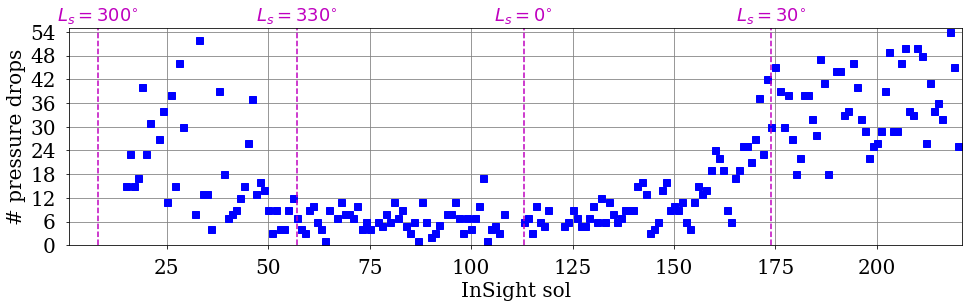

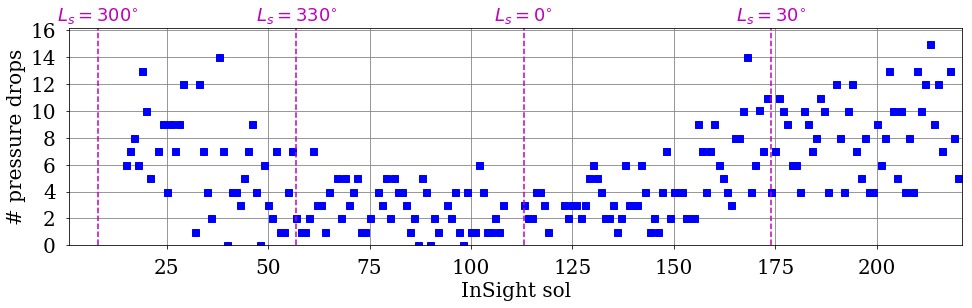

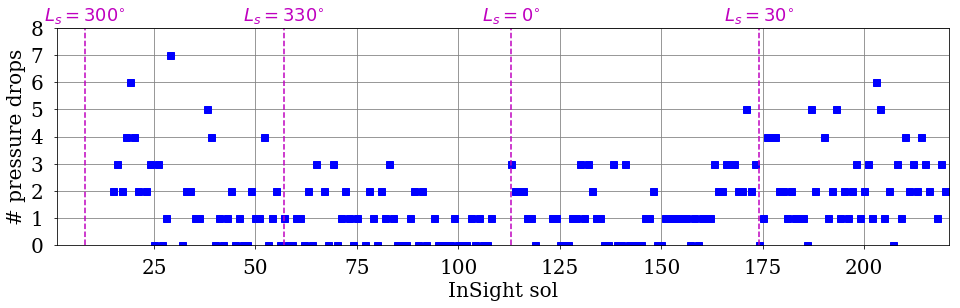

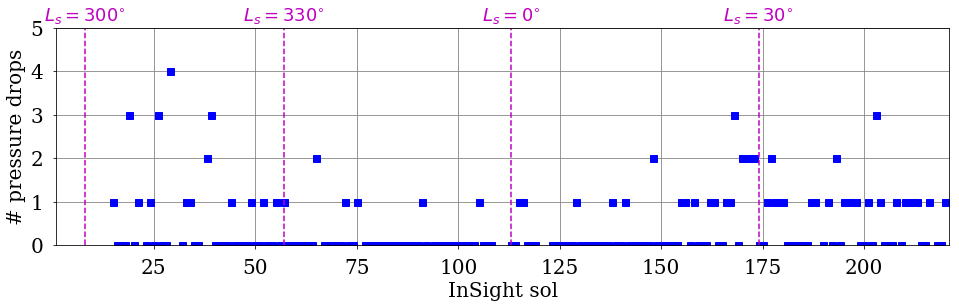

In [8]:
## corrected variability
nx = 16 #32 #24 #16
ny = 4 #6
lim = 0.99 # to select regular (complete) sols
reconstructed = False

ppplot.changefont(20)
ppplot.changemarkersize(7)

stab = ["above_0p3","above_0p5","above_1p0","above_2p0"]
#stab = ["above_0p3"]

#for season in seasontab:
ns = len(seasontab)
for iii in range(ns):    

    season = seasontab[iii]
    ssol,esol = solboundtab[iii]
        
    for sss in stab:

        sol, ratio, ndd, extdrop = np.loadtxt("./solDD_"+sss+".txt",unpack=True,skiprows=1)
        fig = ppplot.figuref(x=nx,y=ny)
        pl = ppplot.plot1d(fig=fig)
        #pl.xmin = sol[0]  - 1.0
        #pl.xmax = sol[-1] + 1.0
        pl.xmin = ssol
        pl.xmax = esol+1
        pl.nxticks = 10 #15 #10
        pl.ymin = 0
        pl.ymax = np.max(ndd/ratio)+1
        pl.nyticks = np.min([pl.ymax - pl.ymin + 1, 10])
        pl.fmt = '%.0f'
        pl.xlabel = "InSight sol"
        pl.ylabel = r'# pressure drops' #per hour'
        pl.linestyle = ""
        pl.marker = "s"
        #pl.title = "pressure drops " + sss.replace("p",".").replace("_"," ") + " Pa"

        ##########################
        ## regular points first
        w = np.where(ratio >= lim)
        pl.f = ndd[w]/ratio[w]
        pl.x = sol[w]
        pl.color = "b"
        pl.make()

        ##########################
        ## reconstructed points second
        if reconstructed:
            w = np.where( (0.5 < ratio) * (ratio <= lim) )
            pl.f = np.floor(ndd[w]/ratio[w])
            pl.x = sol[w]
            pl.color = "c"
            pl.make()

        for tt in apss_lib.ttab:
            sol,ls = tt
            if pl.xmin < sol < pl.xmax:
                pl.x, pl.f = [sol,sol], [pl.ymin,pl.ymax]
                pl.marker, pl.linestyle = "", "--"
                pl.color = 'm'    
                pl.ax.text(sol,pl.ymax*1.05,r'$L_s=%i^{\circ}$'%(ls),\
                  color = pl.color,horizontalalignment='center',verticalalignment='center',\
                  fontsize=18)
                #pl.ax = apss_lib.add_stripes(pl.ax)
                pl.make()
        
        ppplot.save(filename=season+"_drop_dtdvar_"+sss,mode="pdf")




